In [1]:
import cobra
from cobra.io import load_json_model, save_json_model
from cobra import Model, Reaction, Metabolite
import numpy as np
from math import exp
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
ipsc_core = load_json_model('../data/gems/iPSC_core.json')

# fix reaction directions

In [3]:
for rxn_id in ['G6PDH2r','PGI','FBA','GAPD','PGK','PGM','ENO','LDH_L','ACONT','ACONTm','SUCOAS1m',
              'SUCD1m','FUMm','MDHm','ASPTAm','GLUDym','GDHm','ACOAH','ORNTArm','ICDHym']:
    ipsc_core.reactions.get_by_id(rxn_id).lower_bound=0.0

In [4]:
Adata = pd.read_csv('../data/gems/EnzymeActivity.csv')
A_dict = {Adata['Rxn'][i]:Adata['Activity(mmol/hr/g)'][i] for i in range(len(Adata.index))}

In [5]:
print(ipsc_core.medium.keys())

dict_keys(['EX_glc__D_e', 'EX_h_e', 'EX_pi_e', 'EX_o2_e', 'EX_h2o_e', 'EX_chol_e', 'EX_hco3_e', 'EX_na1_e', 'EX_hxan_e', 'EX_so4_e', 'EX_asn__L_e', 'EX_cys__L_e', 'EX_gln__L_e', 'EX_lys__L_e', 'EX_pro__L_e', 'EX_tyr__L_e', 'EX_met__L_e', 'EX_leu__L_e', 'EX_ser__L_e', 'EX_his__L_e', 'EX_thr__L_e', 'EX_phe__L_e', 'EX_arg__L_e', 'EX_ile__L_e', 'EX_val__L_e', 'EX_trp__L_e', 'EX_asp__L_e', 'EX_k_e', 'EX_ala__L_e', 'EX_glu__L_e', 'EX_gly_e'])


In [6]:
ex_aa_list = ['EX_asn__L_e', 'EX_cys__L_e', 'EX_gln__L_e', 'EX_lys__L_e', 'EX_pro__L_e', 
              'EX_tyr__L_e', 'EX_met__L_e', 'EX_leu__L_e', 'EX_ser__L_e', 'EX_his__L_e', 
              'EX_thr__L_e', 'EX_phe__L_e', 'EX_arg__L_e', 'EX_ile__L_e', 'EX_val__L_e', 
              'EX_trp__L_e', 'EX_asp__L_e', 'EX_ala__L_e', 'EX_glu__L_e', 'EX_gly_e']
def set_PA(model, ptot, A_dict):
    t_sector = model.reactions.EX_lac__L_e.flux_expression/A_dict['EX_lac__L_e'] +\
           (-1)*model.reactions.EX_glc__D_e.flux_expression/A_dict['EX_glc__D_e'] +\
             model.reactions.EX_ac_e.flux_expression/A_dict['EX_ac_e']
    for ex_aa in ex_aa_list:
        t_sector = t_sector + (-1)*model.reactions.get_by_id(ex_aa).flux_expression/A_dict['EX_aa_e']
    a_sector = model.reactions.BIOMASS.flux_expression/A_dict['BIOMASS']
    ngam_sector = model.reactions.ATPM.flux_expression/A_dict['ATPM']
    c_sector = model.reactions.ENO.flux_expression/A_dict['ENO']
    for k in A_dict.keys():
        if k not in ['ENO','EX_lac__L_e', 'EX_ac_e','EX_glc__D_e','EX_aa_e','ATPM','BIOMASS']:
            c_sector  = c_sector  + model.reactions.get_by_id(k).flux_expression/A_dict[k]
    PA = model.problem.Constraint( expression = a_sector + c_sector + ngam_sector,
                        name = 'PA', lb= 0, ub = ptot)
    model.add_cons_vars([ PA ])
    return None

def get_NGAM( NGAM_0, r_max, nh4_con, lac_con, k1, k2, z1, z2):
    r = 1+(r_max-1)*(1+exp(-k1*(nh4_con-z1) ))**-1*(1+exp(-k2*(lac_con-z2) ))**-1
    return r* NGAM_0

In [7]:
ptot = 0.56; NGAM_0 = 5.9; #https://doi.org/10.1371/journal.pcbi.1009022
with ipsc_core:
    ex_aa_list = ['EX_asn__L_e', 'EX_cys__L_e', 'EX_gln__L_e', 'EX_lys__L_e', 'EX_pro__L_e', 
              'EX_tyr__L_e', 'EX_met__L_e', 'EX_leu__L_e', 'EX_ser__L_e', 'EX_his__L_e', 
              'EX_thr__L_e', 'EX_phe__L_e', 'EX_arg__L_e', 'EX_ile__L_e', 'EX_val__L_e', 
              'EX_trp__L_e', 'EX_asp__L_e', 'EX_ala__L_e', 'EX_glu__L_e', 'EX_gly_e']
    for rxn_id in ex_aa_list:
        ipsc_core.reactions.get_by_id(rxn_id).upper_bound=0.0
        ipsc_core.reactions.get_by_id(rxn_id).lower_bound=-0.66
    ipsc_core.reactions.EX_glc__D_e.lower_bound=-1.82
    ipsc_core.reactions.ATPM.lower_bound = NGAM_0
    # Proteome constraints
    set_PA(ipsc_core, ptot, A_dict)
    fluxes = cobra.flux_analysis.pfba(ipsc_core).fluxes
    uptake_flux = ipsc_core.summary().uptake_flux
    secretion_flux = ipsc_core.summary().secretion_flux
    print(ipsc_core.summary())

Objective
1.0 BIOMASS = 0.09190167340141858

Uptake
------
Metabolite    Reaction     Flux  C-Number C-Flux
  ala__L_e EX_ala__L_e  0.04127         3  0.74%
  arg__L_e EX_arg__L_e  0.02269         6  0.82%
  asn__L_e EX_asn__L_e  0.07816         4  1.87%
    chol_e   EX_chol_e  0.01393         5  0.42%
  cys__L_e EX_cys__L_e 0.007636         3  0.14%
  glc__D_e EX_glc__D_e     1.82         6 65.38%
  gln__L_e EX_gln__L_e  0.04743         5  1.42%
     gly_e    EX_gly_e     0.66         2  7.90%
    hco3_e   EX_hco3_e  0.02239         1  0.13%
  his__L_e EX_his__L_e 0.008842         6  0.32%
    hxan_e   EX_hxan_e  0.02467         5  0.74%
  ile__L_e EX_ile__L_e  0.02023         6  0.73%
  leu__L_e EX_leu__L_e  0.03927         6  1.41%
  lys__L_e EX_lys__L_e  0.03562         6  1.28%
  met__L_e EX_met__L_e 0.009703         5  0.29%
      o2_e     EX_o2_e    1.315         0  0.00%
  phe__L_e EX_phe__L_e  0.01716         9  0.92%
      pi_e     EX_pi_e   0.8206         0  0.00%
  pro__L_e

In [8]:
# fluxes.to_csv('../data/gems/fluxes_ipsc.csv')

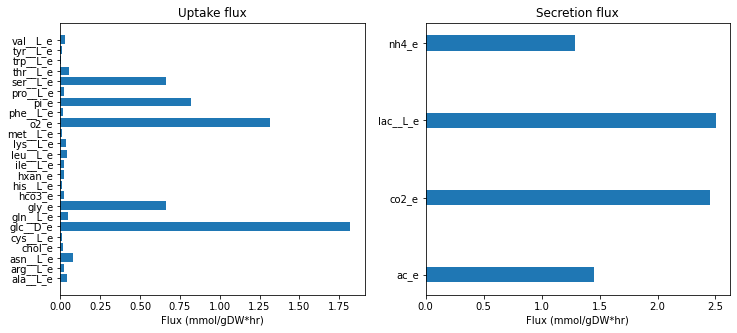

In [9]:
fig, axs = plt.subplots(1,2,figsize=(12,5))
secretion_flux = secretion_flux[(secretion_flux.flux!=0) & ~(secretion_flux.reaction.isin(['EX_h2o_e','EX_h_e']) )]
uptake_flux = uptake_flux[uptake_flux.flux!=0]
axs[0].barh(uptake_flux.metabolite,uptake_flux.flux)
axs[1].barh(secretion_flux.metabolite,-1*secretion_flux.flux, height=0.2)
axs[0].set_title('Uptake flux')
axs[1].set_title('Secretion flux')
for ax in axs:
    ax.set_xlabel('Flux (mmol/gDW*hr)')

In [11]:
ptot = 0.56; NGAM_0 = 5.9; #https://doi.org/10.1371/journal.pcbi.1009022
with ipsc_core:
    ex_aa_list = ['EX_asn__L_e', 'EX_cys__L_e', 'EX_gln__L_e', 'EX_lys__L_e', 'EX_pro__L_e', 
              'EX_tyr__L_e', 'EX_met__L_e', 'EX_leu__L_e', 'EX_ser__L_e', 'EX_his__L_e', 
              'EX_thr__L_e', 'EX_phe__L_e', 'EX_arg__L_e', 'EX_ile__L_e', 'EX_val__L_e', 
              'EX_trp__L_e', 'EX_asp__L_e', 'EX_ala__L_e', 'EX_glu__L_e', 'EX_gly_e']
    for rxn_id in ex_aa_list:
        ipsc_core.reactions.get_by_id(rxn_id).upper_bound=0.0
    ipsc_core.reactions.ATPM.lower_bound = NGAM_0
    # Proteome constraints
    set_PA(ipsc_core, ptot, A_dict)
    fluxes = cobra.flux_analysis.pfba(ipsc_core).fluxes
    uptake_flux = ipsc_core.summary().uptake_flux
    secretion_flux = ipsc_core.summary().secretion_flux
    print(ipsc_core.summary())

Objective
1.0 BIOMASS = 0.093656693362384

Uptake
------
Metabolite    Reaction     Flux  C-Number C-Flux
  ala__L_e EX_ala__L_e  0.04206         3  0.45%
  arg__L_e EX_arg__L_e  0.02313         6  0.49%
  asn__L_e EX_asn__L_e  0.07965         4  1.13%
    chol_e   EX_chol_e  0.01419         5  0.25%
  cys__L_e EX_cys__L_e 0.007781         3  0.08%
  glc__D_e EX_glc__D_e    4.271         6 90.56%
  gln__L_e EX_gln__L_e  0.04834         5  0.85%
     gly_e    EX_gly_e 0.008415         2  0.06%
    hco3_e   EX_hco3_e  0.02282         1  0.08%
  his__L_e EX_his__L_e 0.009011         6  0.19%
    hxan_e   EX_hxan_e  0.02514         5  0.44%
  ile__L_e EX_ile__L_e  0.02062         6  0.44%
  leu__L_e EX_leu__L_e  0.04002         6  0.85%
  lys__L_e EX_lys__L_e  0.03631         6  0.77%
  met__L_e EX_met__L_e 0.009889         5  0.17%
      o2_e     EX_o2_e   0.2847         0  0.00%
  phe__L_e EX_phe__L_e  0.01749         9  0.56%
      pi_e     EX_pi_e   0.8362         0  0.00%
  pro__L_e E

In [12]:
# fluxes.to_csv('../data/gems/fluxes_glc_nocon.csv')

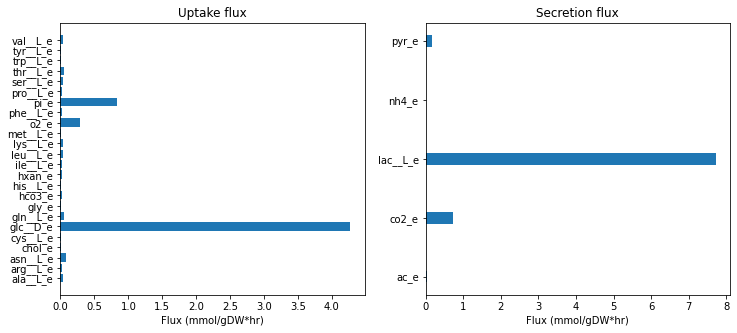

In [13]:
fig, axs = plt.subplots(1,2,figsize=(12,5))
secretion_flux = secretion_flux[(secretion_flux.flux!=0) & ~(secretion_flux.reaction.isin(['EX_h2o_e','EX_h_e']) )]
uptake_flux = uptake_flux[uptake_flux.flux!=0]
axs[0].barh(uptake_flux.metabolite,uptake_flux.flux)
axs[1].barh(secretion_flux.metabolite,-1*secretion_flux.flux, height=0.2)
axs[0].set_title('Uptake flux')
axs[1].set_title('Secretion flux')
for ax in axs:
    ax.set_xlabel('Flux (mmol/gDW*hr)')

In [35]:
def get_fluxes_NGAM(model,  ptot, A_dict, NGAM):
    with model:
        for rxn_id in ex_aa_list:
            ipsc_core.reactions.get_by_id(rxn_id).upper_bound=0.0
        ipsc_core.reactions.EX_glc__D_e.lower_bound=-1.82
        model.reactions.ATPM.lower_bound = NGAM
        # Proteome constraints
        set_PA(model, ptot, A_dict)
        fluxes = cobra.flux_analysis.pfba(model).fluxes
    return fluxes

In [36]:
NGAMs = np.linspace(5.9,10); ptot=0.56;
grs=[]; glc_fluxes=[]; lac_fluxes=[]; nh4_fluxes=[];
for ngam in NGAMs:
    fluxes = get_fluxes_NGAM( ipsc_core,  ptot, A_dict, ngam)
    grs.append(fluxes['BIOMASS'])
    glc_fluxes.append(fluxes['EX_glc__D_e'])
    lac_fluxes.append(fluxes['EX_lac__L_e'])
    nh4_fluxes.append(fluxes['EX_nh4_e'])

Text(0, 0.5, 'NH4 secretion(mmol/gDW*hr)')

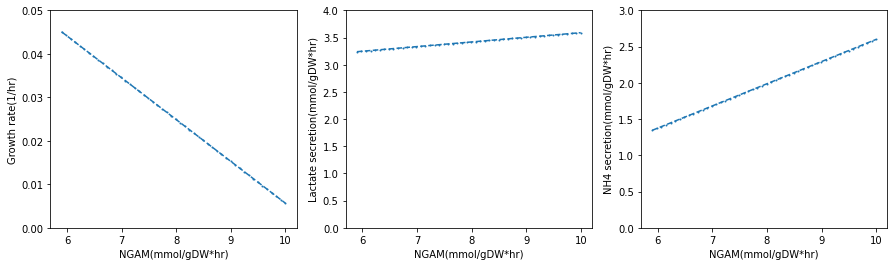

In [49]:
fig,axs=plt.subplots(1,3,figsize=(15,4))
axs[0].plot(NGAMs,grs,'o',markersize=1,ls='--')
axs[0].set_ylim([0,0.05])
axs[1].plot(NGAMs,lac_fluxes,'o',markersize=1,ls='--')
axs[1].set_ylim([0,4])
axs[2].plot(NGAMs,nh4_fluxes,'o',markersize=1,ls='--')
axs[2].set_ylim([0,3])
for ax in axs:
    ax.set_xlabel('NGAM(mmol/gDW*hr)')
axs[0].set_ylabel('Growth rate(1/hr)')
axs[1].set_ylabel('Lactate secretion(mmol/gDW*hr)')
axs[2].set_ylabel('NH4 secretion(mmol/gDW*hr)')

In [21]:
# fluxes_ngam10 = get_fluxes_NGAM(ipsc_core,  0.56, A_dict, 10.0)
# fluxes.to_csv('../data/gems/fluxes_ngam10.csv')